### Trying to fit a single neuron's activity using van Rossum loss (Current-Based Model)

* We generate activity from a neuron driven by a single feedforward excitatory cell
* Then we try to recover this single weight by optimising the van Rossum loss
* This version uses the **feedforward current-based model** instead of conductance-based

In [1]:
import numpy as np
from network_inputs.supervised import (
    CyclicSampler,
)
from network_inputs.unsupervised import HomogeneousPoissonSpikeDataLoader
from network_simulators.feedforward_current_based.simulator import (
    FeedforwardCurrentLIFNetwork,
)
import torch
from torch.utils.data import DataLoader
from torch.amp import GradScaler
from optimisation.loss_functions import (
    VanRossumLoss,
)
from parameter_loaders import StudentTrainingParams
import toml
from visualization.neuronal_dynamics import (
    plot_membrane_voltages,
    plot_synaptic_currents,
)
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

In [2]:
# Define network parameters directly (one excitatory cell type)

# Postsynaptic neuron parameters
cell_params = [
    {
        "name": "excitatory",
        "cell_id": 0,
        "tau_mem": 100.0,  # Membrane time constant (ms)
        "tau_ref": 2.0,   # Refractory period (ms)
        "theta": -50.0,   # Threshold potential (mV) - not used in natural units but kept for visualization
        "E_L": -70.0,     # Resting potential (mV) - not used in natural units but kept for visualization
    }
]

# Feedforward synapse parameters (one excitatory synapse type)
synapse_params_FF = [
    {
        "name": "AMPA",
        "synapse_id": 0,
        "cell_id": 0,  # Presynaptic cell type that produces this synapse
        "tau_syn": 5.0,  # Synaptic time constant (ms)
        "type": "excitatory",  # Excitatory synapse
    }
]

# Hyperparameters
surrgrad_scale = 10.0  # Surrogate gradient scale
van_rossum_tau = 80.0  # Van Rossum loss time constant (ms)

In [3]:
# Define network
dt = 1.0
weights = np.array([[0.1]])
cell_type_indices = np.array([0])
feedforward_mask = np.array([[True]])

model = FeedforwardCurrentLIFNetwork(
    dt=dt,
    weights_FF=weights,
    cell_type_indices=cell_type_indices,
    cell_type_indices_FF=cell_type_indices,
    cell_params=cell_params,
    synapse_params_FF=synapse_params_FF,
    surrgrad_scale=surrgrad_scale,
    batch_size=1,
    optimisable=None,
    feedforward_mask=feedforward_mask,
    track_variables=False,
    use_tqdm=False,
)

In [4]:
# Create Poisson spike dataloader for teacher network
firing_rates = np.array([6.0])  # 6 Hz for single feedforward neuron
chunk_size = 1000.0  # 1 second chunks
n_chunks = 20  # Run for 20 seconds total

spike_dataloader = HomogeneousPoissonSpikeDataLoader(
    firing_rates=firing_rates, chunk_size=chunk_size, dt=dt, batch_size=1, device="cpu"
)

In [5]:
# Generate teacher activity by running the network with input spikes
# Enable variable tracking to collect voltages and currents in one pass
model.reset_state()
model.track_variables = True

all_input_spikes = []
all_output_spikes = []
all_voltages = []
all_currents_syn = []

with torch.no_grad():
    for chunk_idx, (input_spikes_chunk, _) in enumerate(spike_dataloader):
        if chunk_idx >= n_chunks:
            break

        # Run one chunk through the network
        output_dict = model(input_spikes_chunk)

        # Accumulate results
        all_input_spikes.append(input_spikes_chunk)
        all_output_spikes.append(output_dict["spikes"])
        all_voltages.append(output_dict["voltages"])
        all_currents_syn.append(output_dict["currents_syn"])

# Concatenate all chunks along time dimension
input_spikes = torch.cat(all_input_spikes, dim=1)
output_spikes = torch.cat(all_output_spikes, dim=1)
full_voltages = torch.cat(all_voltages, dim=1)
full_currents_syn = torch.cat(all_currents_syn, dim=1)

model.track_variables = False

print(f"Collected {input_spikes.shape[1]} timesteps of data")
print(f"Voltages shape: {full_voltages.shape}")
print(f"Synaptic currents shape: {full_currents_syn.shape}")

Collected 20000 timesteps of data
Voltages shape: torch.Size([1, 20000, 1])
Synaptic currents shape: torch.Size([1, 20000, 1, 1])


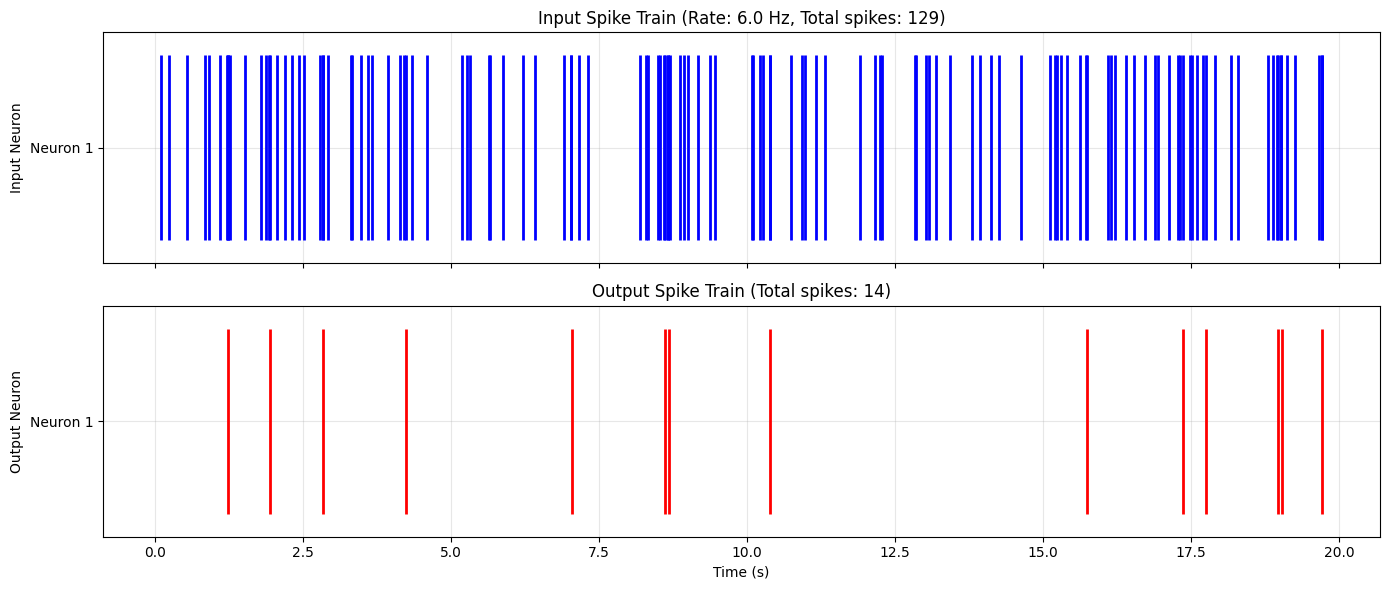

\nInput spike count: 129
Output spike count: 14
Weight value: 0.100


In [6]:
# Visualize input and output spike trains
time_axis = np.arange(input_spikes.shape[1]) * dt / 1000.0  # Convert to seconds
input_spike_indices = torch.where(input_spikes[0, :, 0])[0].numpy()
output_spike_indices = torch.where(output_spikes[0, :, 0])[0].numpy()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Plot input spikes
ax1.eventplot(
    [input_spike_indices * dt / 1000.0],
    lineoffsets=0.5,
    linelengths=0.8,
    color="blue",
    linewidths=2,
)
ax1.set_ylabel("Input Neuron")
ax1.set_title(
    f"Input Spike Train (Rate: {firing_rates[0]} Hz, Total spikes: {len(input_spike_indices)})"
)
ax1.set_ylim([0, 1])
ax1.set_yticks([0.5])
ax1.set_yticklabels(["Neuron 1"])
ax1.grid(True, alpha=0.3)

# Plot output spikes
ax2.eventplot(
    [output_spike_indices * dt / 1000.0],
    lineoffsets=0.5,
    linelengths=0.8,
    color="red",
    linewidths=2,
)
ax2.set_ylabel("Output Neuron")
ax2.set_title(f"Output Spike Train (Total spikes: {len(output_spike_indices)})")
ax2.set_xlabel("Time (s)")
ax2.set_ylim([0, 1])
ax2.set_yticks([0.5])
ax2.set_yticklabels(["Neuron 1"])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\\nInput spike count: {len(input_spike_indices)}")
print(f"Output spike count: {len(output_spike_indices)}")
print(f"Weight value: {model.weights_FF.data[0, 0].item():.3f}")

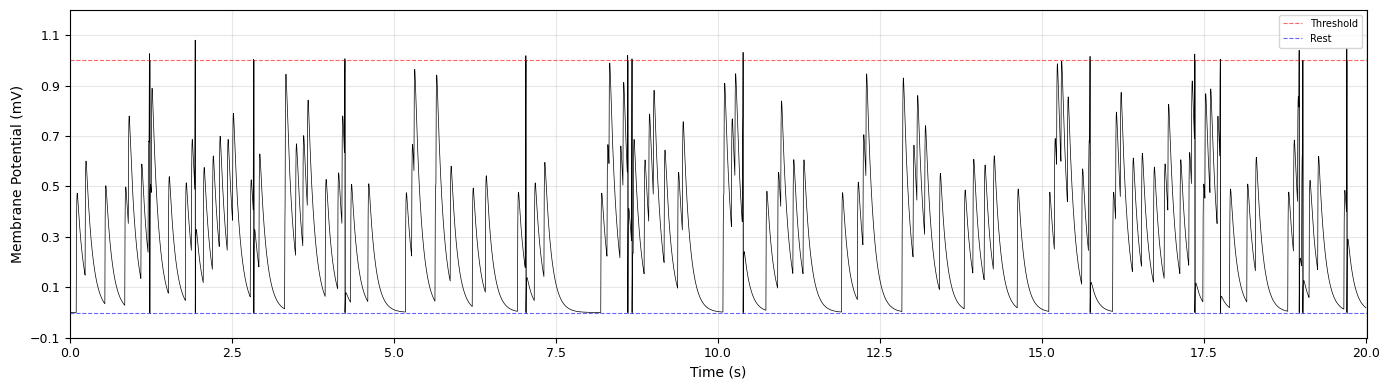

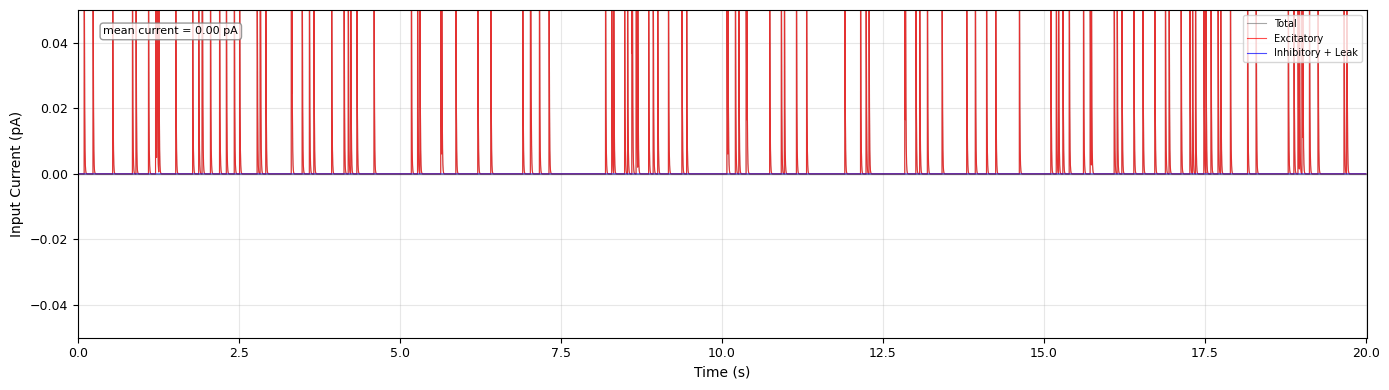

In [7]:
# Map parameters to expected format for plotting functions
# Current-based model uses natural units: v ∈ [0, 1] where 0 is reset and 1 is threshold
neuron_params_mapped = {
    0: {
        "threshold": 1.0,  # Threshold in natural units
        "rest": 0.0,       # Reset/rest in natural units
        "tau_mem": cell_params[0]["tau_mem"],
    }
}

# Plot membrane potential with natural units y-axis
fig1 = plot_membrane_voltages(
    voltages=full_voltages.cpu().numpy(),
    spikes=output_spikes.cpu().numpy(),
    neuron_types=cell_type_indices,
    delta_t=dt,
    neuron_params=neuron_params_mapped,
    n_neurons_plot=1,
    fraction=1.0,
    y_min=-0.1,      # Natural units: 0 = reset, add margin below
    y_max=1.2,       # Natural units: 1 = threshold, add margin above
    y_tick_step=0.2,
    figsize=(14, 4),
)

# Plot synaptic currents
# Current-based model: sum currents across all synapse types
# Currents are already signed correctly (excitatory positive, inhibitory negative)
I_syn_total = full_currents_syn.sum(dim=-1).cpu().numpy()  # Sum across synapse types

fig2 = plot_synaptic_currents(
    I_exc=I_syn_total,
    I_inh=np.zeros_like(I_syn_total),  # No separate leak current in current-based model
    I_tot=I_syn_total,
    delta_t=dt,
    n_neurons_plot=1,
    fraction=1.0,
    show_total=True,
    neuron_types=cell_type_indices,
    neuron_params=neuron_params_mapped,
    figsize=(14, 4),
)

plt.show()


In [8]:
# Create student network with different weight to train
student_weight = 0.2

student_model = FeedforwardCurrentLIFNetwork(
    dt=dt,
    weights_FF=np.array([[student_weight]]),
    cell_type_indices=cell_type_indices,
    cell_type_indices_FF=cell_type_indices,
    cell_params=cell_params,
    synapse_params_FF=synapse_params_FF,
    surrgrad_scale=surrgrad_scale,
    batch_size=1,
    optimisable="weights",  # Make weights trainable
    feedforward_mask=feedforward_mask,
    track_variables=False,
    use_tqdm=False,
)

# Initialize Van Rossum loss
van_rossum_loss_fn = VanRossumLoss(
    tau=van_rossum_tau,
    dt=dt,
    window_size=100,  # Must be integer
    device="cpu",
)

# Setup optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.05)

# Setup learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-4
)

# Mixed precision scaler (disabled for CPU)
scaler = GradScaler("cpu", enabled=False)

print(f"Student network initialized with weight: {student_weight}")
print(f"Teacher network weight: {model.weights_FF.data[0, 0].item():.3f}")
print(f"Van Rossum loss tau: {van_rossum_tau}ms")

Student network initialized with weight: 0.2
Teacher network weight: 0.100
Van Rossum loss tau: 80.0ms


In [9]:
# Create PrecomputedSpikeDataset from our teacher data
# We need to save the teacher spikes in the format the trainer expects

# Create dataset that returns input and target (teacher output) spikes
class SimpleSpikeDataset(torch.utils.data.Dataset):
    def __init__(self, input_spikes, target_spikes, chunk_size_timesteps):
        """
        Args:
            input_spikes: Tensor of shape (batch, time, neurons)
            target_spikes: Tensor of shape (batch, time, neurons)
            chunk_size_timesteps: Number of timesteps per chunk
        """
        self.input_spikes = input_spikes
        self.target_spikes = target_spikes
        self.chunk_size = chunk_size_timesteps
        self.num_chunks = input_spikes.shape[1] // chunk_size_timesteps
        self.batch_size = input_spikes.shape[0]
        self.dt = dt

    def __len__(self):
        return self.num_chunks

    def __getitem__(self, idx):
        start_idx = idx * self.chunk_size
        end_idx = start_idx + self.chunk_size

        input_chunk = self.input_spikes[:, start_idx:end_idx, :]
        target_chunk = self.target_spikes[:, start_idx:end_idx, :]

        return input_chunk, target_chunk


# Create dataset from our teacher data
chunk_size_timesteps = int(chunk_size)
spike_dataset = SimpleSpikeDataset(
    input_spikes=input_spikes,
    target_spikes=output_spikes,
    chunk_size_timesteps=chunk_size_timesteps,
)

# Create cyclic sampler for training
spike_dataloader = DataLoader(
    spike_dataset,
    batch_size=None,  # Already batched
    sampler=CyclicSampler(spike_dataset),
    num_workers=0,
)

print(f"Created dataset with {spike_dataset.num_chunks} chunks")
print(f"Chunk size: {chunk_size_timesteps} timesteps ({chunk_size}ms)")

Created dataset with 20 chunks
Chunk size: 1000 timesteps (1000.0ms)


Exploring loss landscape with different weight values...


Grid search: 100%|██████████| 41/41 [01:02<00:00,  1.53s/it]


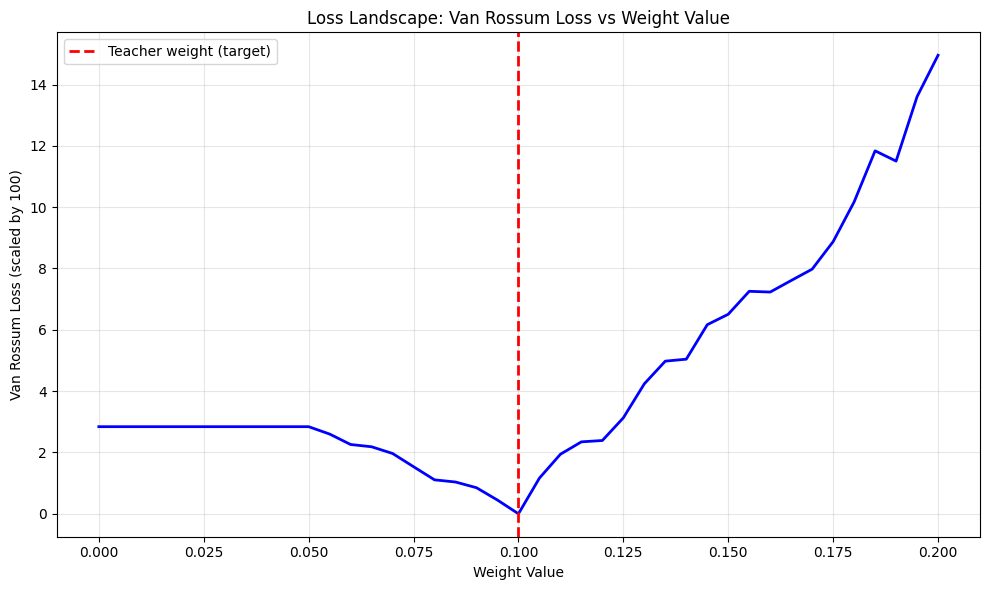


Target weight: 0.100
Minimum loss at weight: 0.100


In [10]:
# Grid search over weight values to visualize loss landscape
print("Exploring loss landscape with different weight values...")
weight_values = np.arange(0.0, 0.2 + 0.005, 0.005)
losses = []

for weight in tqdm(weight_values, desc="Grid search"):
    # Create temporary model with this weight
    temp_model = FeedforwardCurrentLIFNetwork(
        dt=dt,
        weights_FF=np.array([[weight]]),
        cell_type_indices=cell_type_indices,
        cell_type_indices_FF=cell_type_indices,
        cell_params=cell_params,
        synapse_params_FF=synapse_params_FF,
        surrgrad_scale=surrgrad_scale,
        batch_size=1,
        optimisable=None,
        feedforward_mask=feedforward_mask,
        track_variables=False,
        use_tqdm=False,
    )

    # Compute loss for all chunks
    total_loss = 0.0
    temp_model.reset_state()

    with torch.no_grad():
        for chunk_idx in range(min(10, spike_dataset.num_chunks)):
            input_chunk, target_chunk = spike_dataset[chunk_idx]
            output_spikes = temp_model(input_chunk)
            loss = 100 * van_rossum_loss_fn(output_spikes, target_chunk)
            total_loss += loss.item()

    losses.append(total_loss / min(10, spike_dataset.num_chunks))

# Plot loss landscape
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(weight_values, losses, linewidth=2, color="blue")
ax.axvline(
    x=model.weights_FF.data[0, 0].item(),
    color="red",
    linestyle="--",
    linewidth=2,
    label="Teacher weight (target)",
)
ax.set_xlabel("Weight Value")
ax.set_ylabel("Van Rossum Loss (scaled by 100)")
ax.set_title("Loss Landscape: Van Rossum Loss vs Weight Value")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTarget weight: {model.weights_FF.data[0, 0].item():.3f}")
print(f"Minimum loss at weight: {weight_values[np.argmin(losses)]:.3f}")

In [11]:
# Training parameters - set manually
chunk_size = 2000  # timesteps per chunk
n_chunks = 10  # chunks in the recording
epochs = 100  # times to loop through recording

print("Training configuration:")
print(f"  Chunk size: {chunk_size} timesteps")
print(f"  Chunks per epoch: {n_chunks}")
print(f"  Epochs: {epochs}")
print(f"  Total iterations: {epochs * n_chunks}")
print(f"\nInitial student weight: {student_model.weights_FF.data[0, 0].item():.6f}")
print(f"Target teacher weight: {model.weights_FF.data[0, 0].item():.6f}")

Training configuration:
  Chunk size: 2000 timesteps
  Chunks per epoch: 10
  Epochs: 100
  Total iterations: 1000

Initial student weight: 0.200000
Target teacher weight: 0.100000


In [12]:
# Run training with single initialization
initial_weight = 0.2

# Reset student model with new weight
student_model.weights_FF.data[0, 0] = initial_weight

# Ensure weights require gradients
student_model.weights_FF.requires_grad_(True)

# Reset optimizer and scheduler
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-4
)

# Track losses and weights
epoch_losses = []
epoch_weights = []

print("\nStarting training...")
print("=" * 60)
print(f"Initial weight: {initial_weight:.6f}")
print(f"Target weight: {model.weights_FF.data[0, 0].item():.6f}")
print("=" * 60)

for epoch in tqdm(range(epochs), desc="Training"):
    epoch_loss_sum = 0.0
    
    # Reset state at the beginning of each epoch for independent simulation
    student_model.reset_state()

    # Loop through all chunks in the recording
    for chunk_idx in range(n_chunks):
        # Get chunk data
        input_chunk, target_chunk = spike_dataset[chunk_idx]

        # Forward pass
        optimizer.zero_grad()
        output_spikes = student_model(input_chunk)

        # Compute loss
        loss = 100 * van_rossum_loss_fn(output_spikes, target_chunk)

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accumulate loss (use .item() to detach from graph)
        epoch_loss_sum += loss.item()

    # Record epoch statistics
    avg_epoch_loss = epoch_loss_sum / n_chunks
    current_weight = student_model.weights_FF.data[0, 0].item()

    epoch_losses.append(avg_epoch_loss)
    epoch_weights.append(current_weight)

print("\n" + "=" * 60)
print("Training complete!")
print("=" * 60)
print(f"Initial weight: {epoch_weights[0]:.6f}")
print(f"Final weight: {epoch_weights[-1]:.6f}")
print(f"Target weight: {model.weights_FF.data[0, 0].item():.6f}")
print(f"Weight error: {abs(epoch_weights[-1] - model.weights_FF.data[0, 0].item()):.6f}")
print(f"Loss reduction: {((epoch_losses[0] - epoch_losses[-1]) / epoch_losses[0] * 100):.1f}%")
print(f"\nInitial loss: {epoch_losses[0]:.6f}")
print(f"Final loss: {epoch_losses[-1]:.6f}")
print("=" * 60)


Starting training...
Initial weight: 0.200000
Target weight: 0.100000


Training: 100%|██████████| 100/100 [07:12<00:00,  4.33s/it]


Training complete!
Initial weight: 0.154836
Final weight: 0.099651
Target weight: 0.100000
Weight error: 0.000349
Loss reduction: 100.0%

Initial loss: 7.616504
Final loss: 0.000000


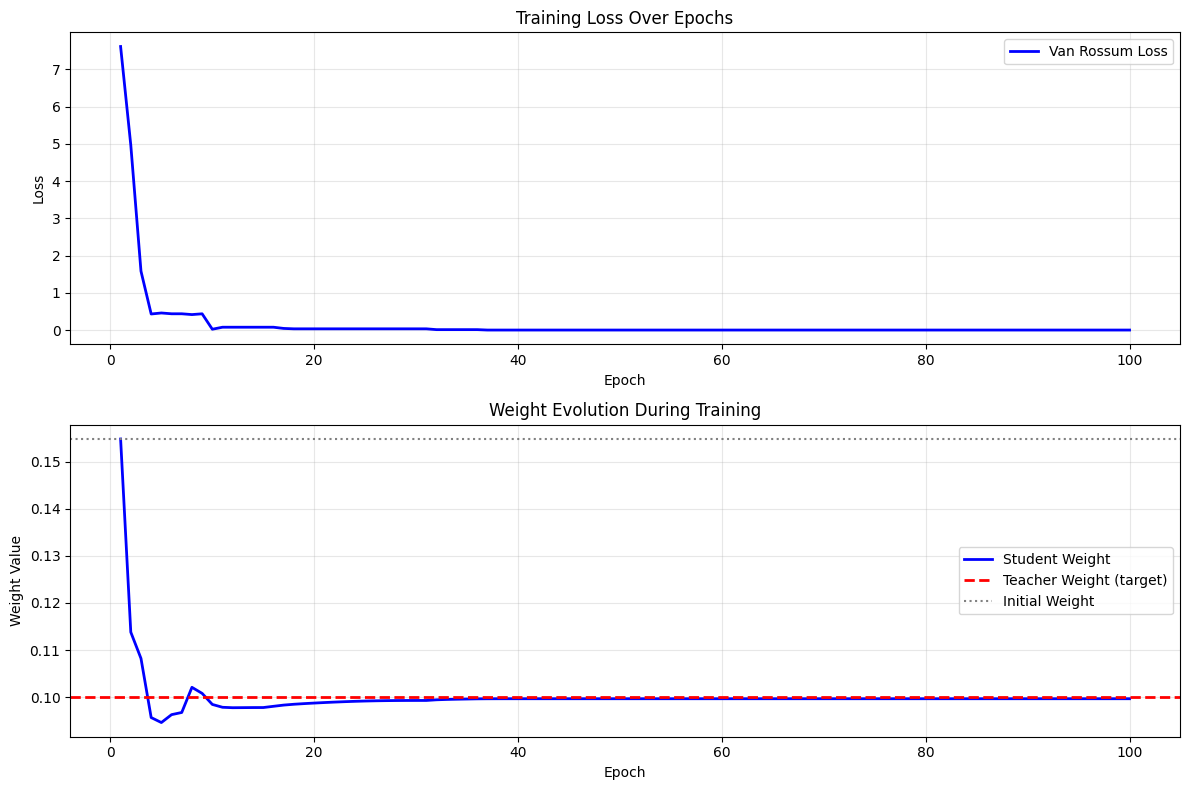


Training Summary:
Initial weight: 0.154836
Final weight: 0.099651
Target weight: 0.100000
Weight error: 0.000349
Loss reduction: 100.0%

Initial loss: 7.616504
Final loss: 0.000000


In [13]:
# Plot loss and weight evolution

epoch_numbers = np.arange(1, epochs + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot total loss
ax1.plot(
    epoch_numbers,
    epoch_losses,
    label="Van Rossum Loss",
    linewidth=2,
    color="blue",
)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss Over Epochs")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot learned weight
ax2.plot(
    epoch_numbers, epoch_weights, label="Student Weight", linewidth=2, color="blue"
)
ax2.axhline(
    y=model.weights_FF.data[0, 0].item(),
    color="red",
    linestyle="--",
    linewidth=2,
    label="Teacher Weight (target)",
)
ax2.axhline(
    y=epoch_weights[0],
    color="gray",
    linestyle=":",
    linewidth=1.5,
    label="Initial Weight",
)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Weight Value")
ax2.set_title("Weight Evolution During Training")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTraining Summary:")
print("=" * 60)
print(f"Initial weight: {epoch_weights[0]:.6f}")
print(f"Final weight: {epoch_weights[-1]:.6f}")
print(f"Target weight: {model.weights_FF.data[0, 0].item():.6f}")
print(f"Weight error: {abs(epoch_weights[-1] - model.weights_FF.data[0, 0].item()):.6f}")
print(f"Loss reduction: {((epoch_losses[0] - epoch_losses[-1]) / epoch_losses[0] * 100):.1f}%")
print(f"\nInitial loss: {epoch_losses[0]:.6f}")
print(f"Final loss: {epoch_losses[-1]:.6f}")

### Changing van Rossum tau

In [15]:
# Grid search over weight values with varying tau values
print("Exploring loss landscape with different weight and tau values...")

# Create 10 tau values from 10 to 100
tau_values = np.linspace(10, 100, 10)
weight_values = np.arange(0.0, 0.2 + 0.005, 0.005)

# Store all losses for each tau value
all_tau_losses = []

for tau_idx, tau in enumerate(tau_values):
    print(f"\nProcessing tau = {tau:.1f} ({tau_idx + 1}/10)")

    # Create van Rossum loss function with this tau
    temp_van_rossum_loss_fn = VanRossumLoss(
        tau=tau, dt=dt, window_size=100, device="cpu"
    )

    losses = []

    for weight in tqdm(weight_values, desc=f"tau={tau:.1f}", leave=False):
        # Create temporary model with this weight
        temp_model = FeedforwardCurrentLIFNetwork(
            dt=dt,
            weights_FF=np.array([[weight]]),
            cell_type_indices=cell_type_indices,
            cell_type_indices_FF=cell_type_indices,
            cell_params=cell_params,
            synapse_params_FF=synapse_params_FF,
            surrgrad_scale=surrgrad_scale,
            batch_size=1,
            optimisable=None,
            feedforward_mask=feedforward_mask,
            track_variables=False,
            use_tqdm=False,
        )

        # Compute loss for all chunks
        total_loss = 0.0
        temp_model.reset_state()

        with torch.no_grad():
            for chunk_idx in range(min(10, spike_dataset.num_chunks)):
                input_chunk, target_chunk = spike_dataset[chunk_idx]
                output_spikes = temp_model(input_chunk)  # Returns spikes directly when track_variables=False
                loss = 100 * temp_van_rossum_loss_fn(output_spikes, target_chunk)
                total_loss += loss.item()

        losses.append(total_loss / min(10, spike_dataset.num_chunks))

    all_tau_losses.append(losses)

    # Print minimum loss location
    min_weight = weight_values[np.argmin(losses)]
    print(f"  Minimum loss at weight: {min_weight:.3f}")

print("\nDone computing loss landscapes!")

Exploring loss landscape with different weight and tau values...

Processing tau = 10.0 (1/10)


  Minimum loss at weight: 0.100

Processing tau = 20.0 (2/10)


  Minimum loss at weight: 0.100

Processing tau = 30.0 (3/10)


  Minimum loss at weight: 0.100

Processing tau = 40.0 (4/10)


  Minimum loss at weight: 0.100

Processing tau = 50.0 (5/10)


  Minimum loss at weight: 0.100

Processing tau = 60.0 (6/10)


  Minimum loss at weight: 0.100

Processing tau = 70.0 (7/10)


  Minimum loss at weight: 0.100

Processing tau = 80.0 (8/10)


  Minimum loss at weight: 0.100

Processing tau = 90.0 (9/10)


  Minimum loss at weight: 0.100

Processing tau = 100.0 (10/10)


  Minimum loss at weight: 0.100

Done computing loss landscapes!


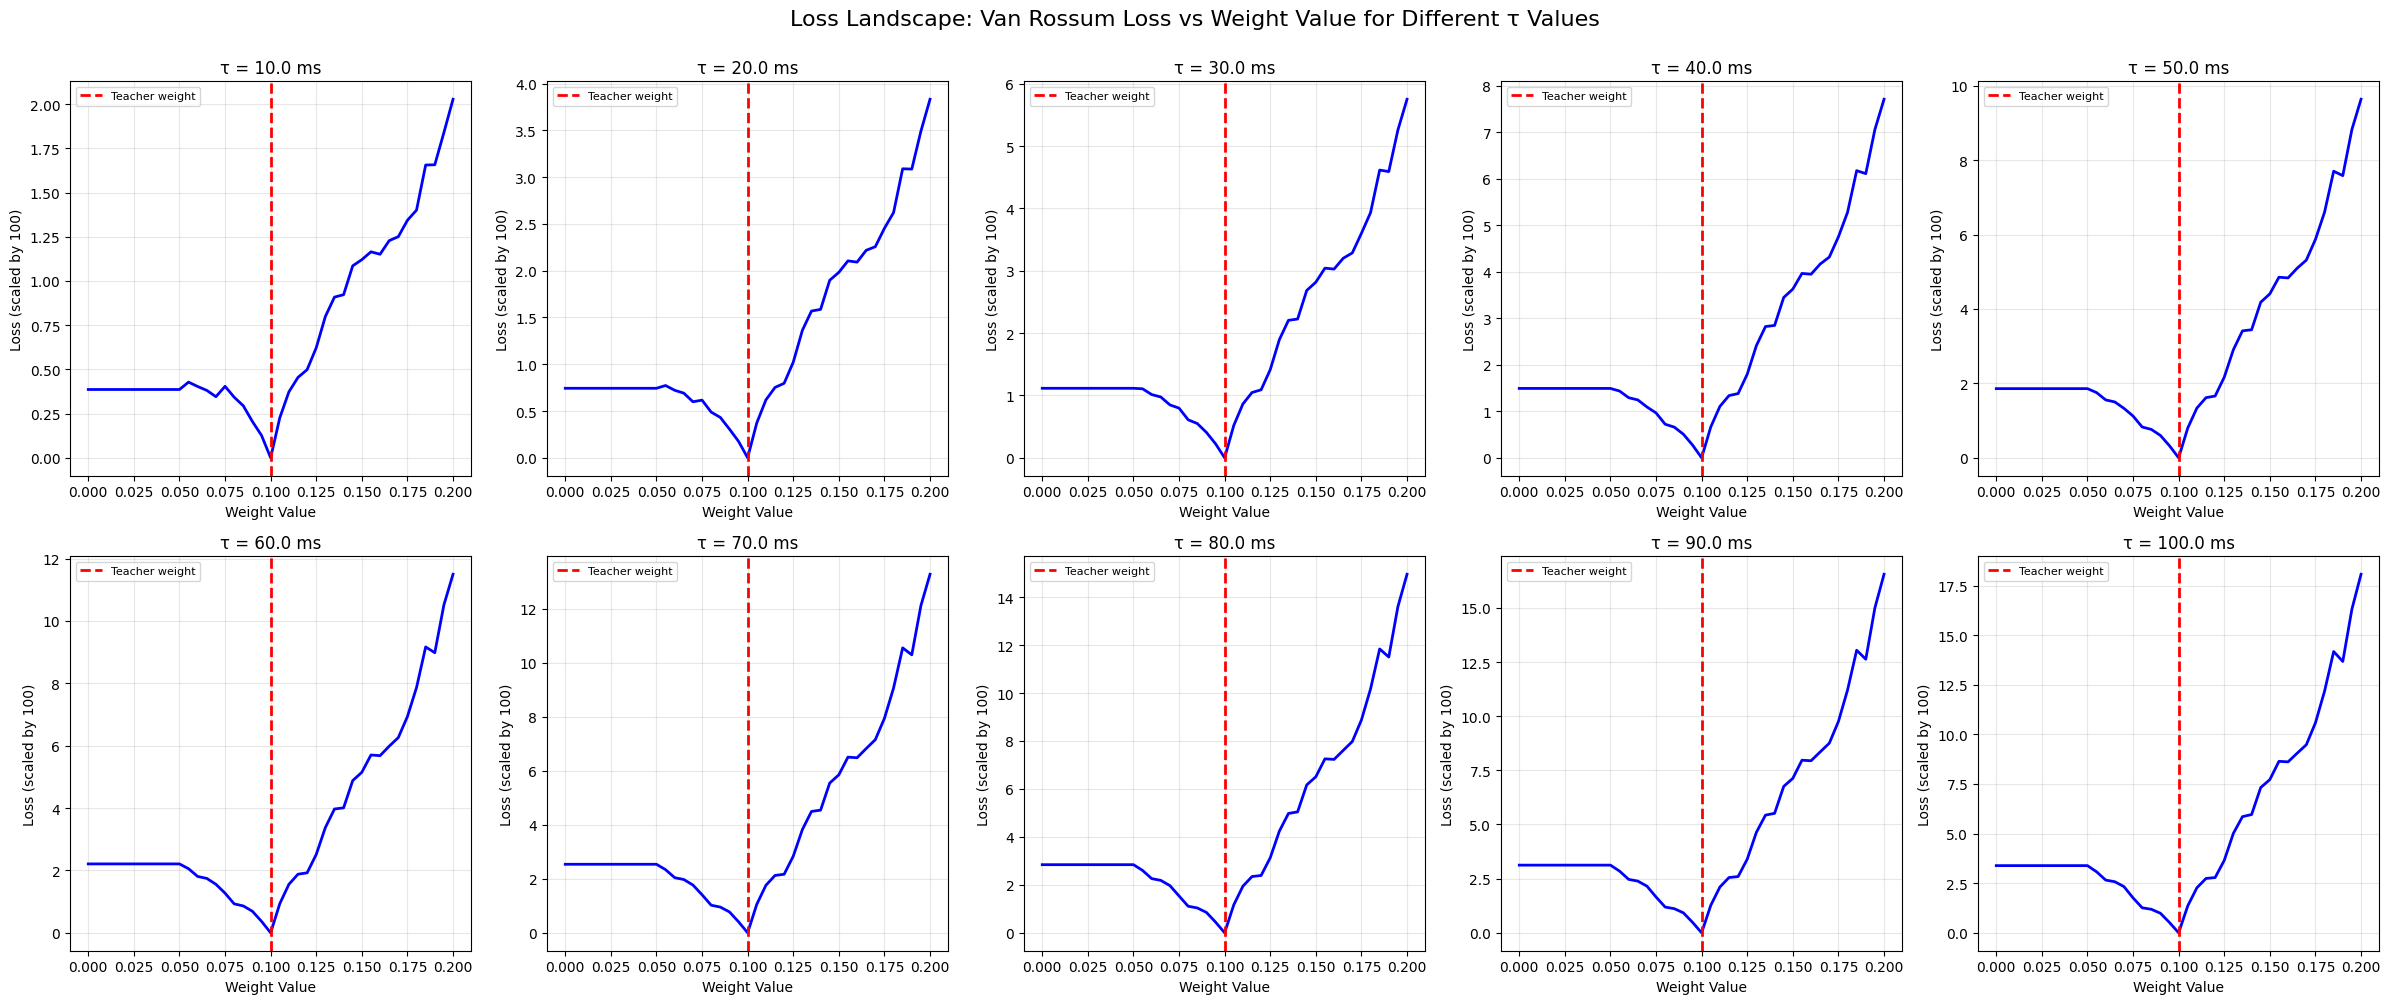


Target weight: 0.100


In [16]:
# Plot all loss landscapes
fig, axes = plt.subplots(2, 5, figsize=(24, 10))
axes = axes.flatten()

for tau_idx, tau in enumerate(tau_values):
    ax = axes[tau_idx]
    losses = all_tau_losses[tau_idx]

    ax.plot(weight_values, losses, linewidth=2, color="blue")
    ax.axvline(
        x=model.weights_FF.data[0, 0].item(),
        color="red",
        linestyle="--",
        linewidth=2,
        label="Teacher weight",
    )
    ax.set_xlabel("Weight Value")
    ax.set_ylabel("Loss (scaled by 100)")
    ax.set_title(f"τ = {tau:.1f} ms")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    "Loss Landscape: Van Rossum Loss vs Weight Value for Different τ Values",
    fontsize=16,
    y=1.00,
)
plt.tight_layout()
plt.show()

print(f"\nTarget weight: {model.weights_FF.data[0, 0].item():.3f}")

In [17]:
# Grid search over weight values with varying tau values (100-1000 ms)
print("Exploring loss landscape with tau values from 100 to 1000 ms...")

# Create 10 tau values from 100 to 1000 in steps of 100
tau_values_large = np.arange(100, 1100, 100)
weight_values = np.arange(0.0, 0.2 + 0.005, 0.005)

# Store all losses for each tau value
all_tau_losses_large = []

for tau_idx, tau in enumerate(tau_values_large):
    print(f"\nProcessing tau = {tau:.0f} ({tau_idx + 1}/10)")

    # Create van Rossum loss function with this tau
    temp_van_rossum_loss_fn = VanRossumLoss(
        tau=tau, dt=dt, window_size=100, device="cpu"
    )

    losses = []

    for weight in tqdm(weight_values, desc=f"tau={tau:.0f}", leave=False):
        # Create temporary model with this weight
        temp_model = FeedforwardCurrentLIFNetwork(
            dt=dt,
            weights_FF=np.array([[weight]]),
            cell_type_indices=cell_type_indices,
            cell_type_indices_FF=cell_type_indices,
            cell_params=cell_params,
            synapse_params_FF=synapse_params_FF,
            surrgrad_scale=surrgrad_scale,
            batch_size=1,
            optimisable=None,
            feedforward_mask=feedforward_mask,
            track_variables=False,
            use_tqdm=False,
        )

        # Compute loss for all chunks
        total_loss = 0.0
        temp_model.reset_state()

        with torch.no_grad():
            for chunk_idx in range(min(10, spike_dataset.num_chunks)):
                input_chunk, target_chunk = spike_dataset[chunk_idx]
                output_spikes = temp_model(input_chunk)  # Returns spikes directly when track_variables=False
                loss = 100 * temp_van_rossum_loss_fn(output_spikes, target_chunk)
                total_loss += loss.item()

        losses.append(total_loss / min(10, spike_dataset.num_chunks))

    all_tau_losses_large.append(losses)

    # Print minimum loss location
    min_weight = weight_values[np.argmin(losses)]
    print(f"  Minimum loss at weight: {min_weight:.3f}")

print("\nDone computing loss landscapes for large tau values!")

Exploring loss landscape with tau values from 100 to 1000 ms...

Processing tau = 100 (1/10)


  Minimum loss at weight: 0.100

Processing tau = 200 (2/10)


  Minimum loss at weight: 0.100

Processing tau = 300 (3/10)


  Minimum loss at weight: 0.100

Processing tau = 400 (4/10)


  Minimum loss at weight: 0.100

Processing tau = 500 (5/10)


  Minimum loss at weight: 0.100

Processing tau = 600 (6/10)


  Minimum loss at weight: 0.100

Processing tau = 700 (7/10)


  Minimum loss at weight: 0.100

Processing tau = 800 (8/10)


  Minimum loss at weight: 0.100

Processing tau = 900 (9/10)


  Minimum loss at weight: 0.100

Processing tau = 1000 (10/10)


  Minimum loss at weight: 0.100

Done computing loss landscapes for large tau values!


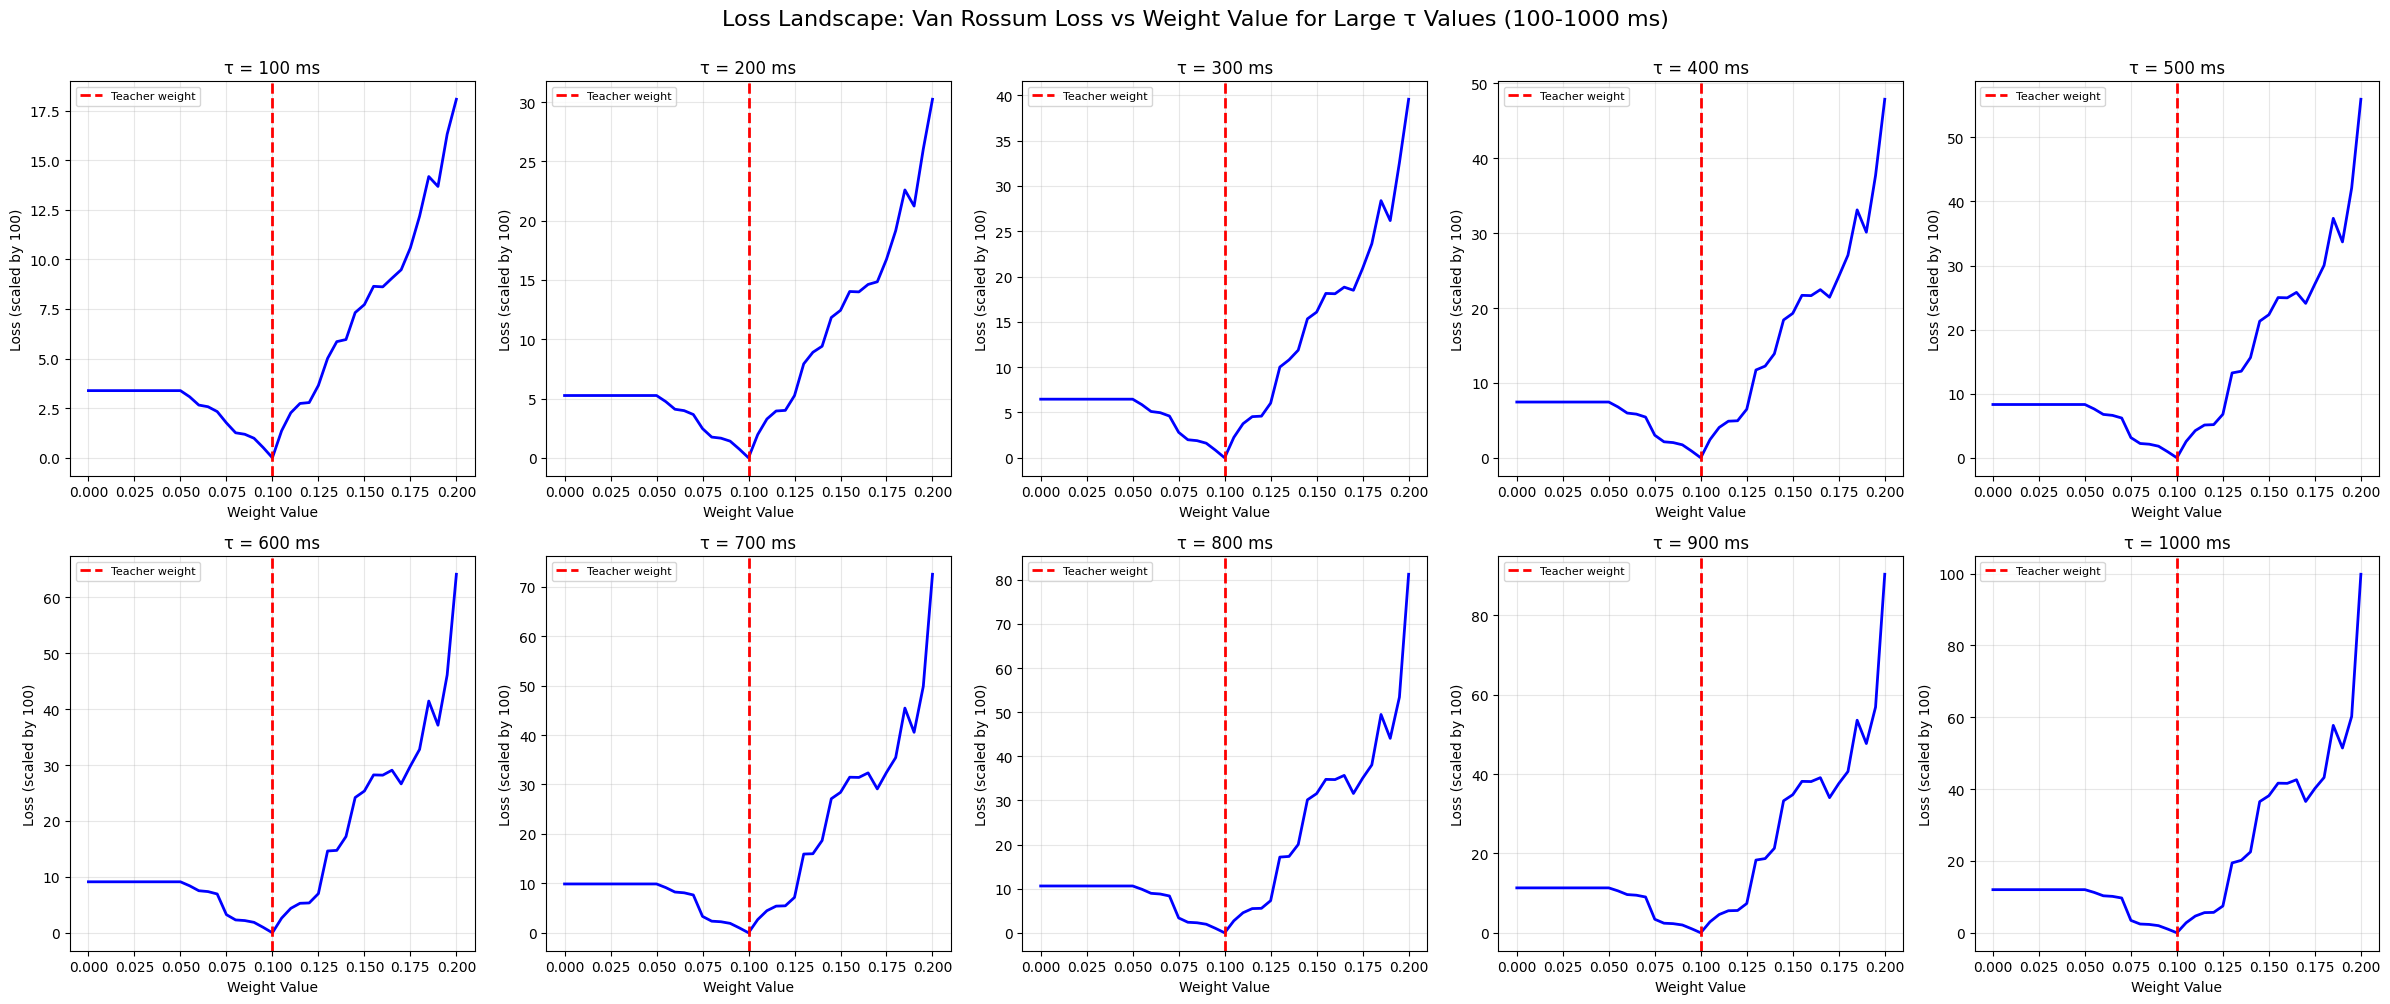


Target weight: 0.100


In [19]:
# Plot all loss landscapes for large tau values (100-1000 ms)
fig, axes = plt.subplots(2, 5, figsize=(24, 10))
axes = axes.flatten()

for tau_idx, tau in enumerate(tau_values_large):
    ax = axes[tau_idx]
    losses = all_tau_losses_large[tau_idx]

    ax.plot(weight_values, losses, linewidth=2, color="blue")
    ax.axvline(
        x=model.weights_FF.data[0, 0].item(),
        color="red",
        linestyle="--",
        linewidth=2,
        label="Teacher weight",
    )
    ax.set_xlabel("Weight Value")
    ax.set_ylabel("Loss (scaled by 100)")
    ax.set_title(f"τ = {tau:.0f} ms")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    "Loss Landscape: Van Rossum Loss vs Weight Value for Large τ Values (100-1000 ms)",
    fontsize=16,
    y=1.00,
)
plt.tight_layout()
plt.show()

print(f"\nTarget weight: {model.weights_FF.data[0, 0].item():.3f}")

### Explicitly plotting gradients across the landscape

We will fix tau=70ms from now on.

In [20]:
# Compute loss landscape AND gradients for tau=70ms
print("Computing loss landscape and gradients for tau=70ms...")

tau_fixed = 70.0
weight_values_grad = np.arange(0.0, 0.2 + 0.005, 0.005)

# Create van Rossum loss function with tau=70ms
van_rossum_loss_70 = VanRossumLoss(tau=tau_fixed, dt=dt, window_size=100, device="cpu")

losses_grad = []
gradients = []
firing_rates = []
mean_voltages = []
std_voltages = []

for weight in tqdm(weight_values_grad, desc=f"tau={tau_fixed:.0f}ms"):
    # Create temporary model with this weight - make it optimizable to get gradients
    temp_model = FeedforwardCurrentLIFNetwork(
        dt=dt,
        weights_FF=np.array([[weight]]),
        cell_type_indices=cell_type_indices,
        cell_type_indices_FF=cell_type_indices,
        cell_params=cell_params,
        synapse_params_FF=synapse_params_FF,
        surrgrad_scale=surrgrad_scale,
        batch_size=1,
        optimisable="weights",  # Enable gradients
        feedforward_mask=feedforward_mask,
        track_variables=True,  # Enable to track voltages
        use_tqdm=False,
    )

    # Get the actual weight parameter (should be a leaf tensor)
    weight_param = list(temp_model.parameters())[0]

    # Compute loss for all chunks WITH gradients
    total_loss = 0.0
    total_spikes = 0.0
    total_time = 0.0
    all_voltages = []
    temp_model.reset_state()

    # Zero out any existing gradients
    if weight_param.grad is not None:
        weight_param.grad.zero_()

    for chunk_idx in range(min(10, spike_dataset.num_chunks)):
        input_chunk, target_chunk = spike_dataset[chunk_idx]
        output_dict = temp_model(input_chunk)

        # Get output spikes
        output_spikes = output_dict["spikes"]

        loss = 100 * van_rossum_loss_70(output_spikes, target_chunk)
        loss.backward()  # Compute gradients
        total_loss += loss.item()

        # Count spikes for firing rate
        total_spikes += output_spikes.sum().item()
        total_time += output_spikes.shape[1] * dt  # milliseconds

        # Collect voltages
        if "voltages" in output_dict:
            all_voltages.append(output_dict["voltages"].detach())

    # Compute average loss
    avg_loss = total_loss / min(10, spike_dataset.num_chunks)

    # Access gradient - handle both 1D and 2D cases
    if weight_param.grad.ndim == 1:
        avg_gradient = weight_param.grad[0].item() / min(10, spike_dataset.num_chunks)
    else:
        avg_gradient = weight_param.grad[0, 0].item() / min(
            10, spike_dataset.num_chunks
        )

    # Compute firing rate in Hz (spikes per second)
    firing_rate_hz = (total_spikes / total_time) * 1000.0

    # Compute voltage statistics if available (note: current-based uses natural units 0-1)
    if len(all_voltages) > 0:
        voltages_concat = torch.cat(all_voltages, dim=1)  # (batch, time, neurons)
        mean_v = voltages_concat.mean().item()
        std_v = voltages_concat.std().item()
    else:
        mean_v = 0.0
        std_v = 0.0

    # Store all computed values
    losses_grad.append(avg_loss)
    gradients.append(avg_gradient)
    firing_rates.append(firing_rate_hz)
    mean_voltages.append(mean_v)
    std_voltages.append(std_v)

print(
    f"Done! Computed {len(losses_grad)} loss values and {len(gradients)} gradient values."
)

Computing loss landscape and gradients for tau=70ms...


tau=70ms: 100%|██████████| 41/41 [03:04<00:00,  4.51s/it]

Done! Computed 41 loss values and 41 gradient values.


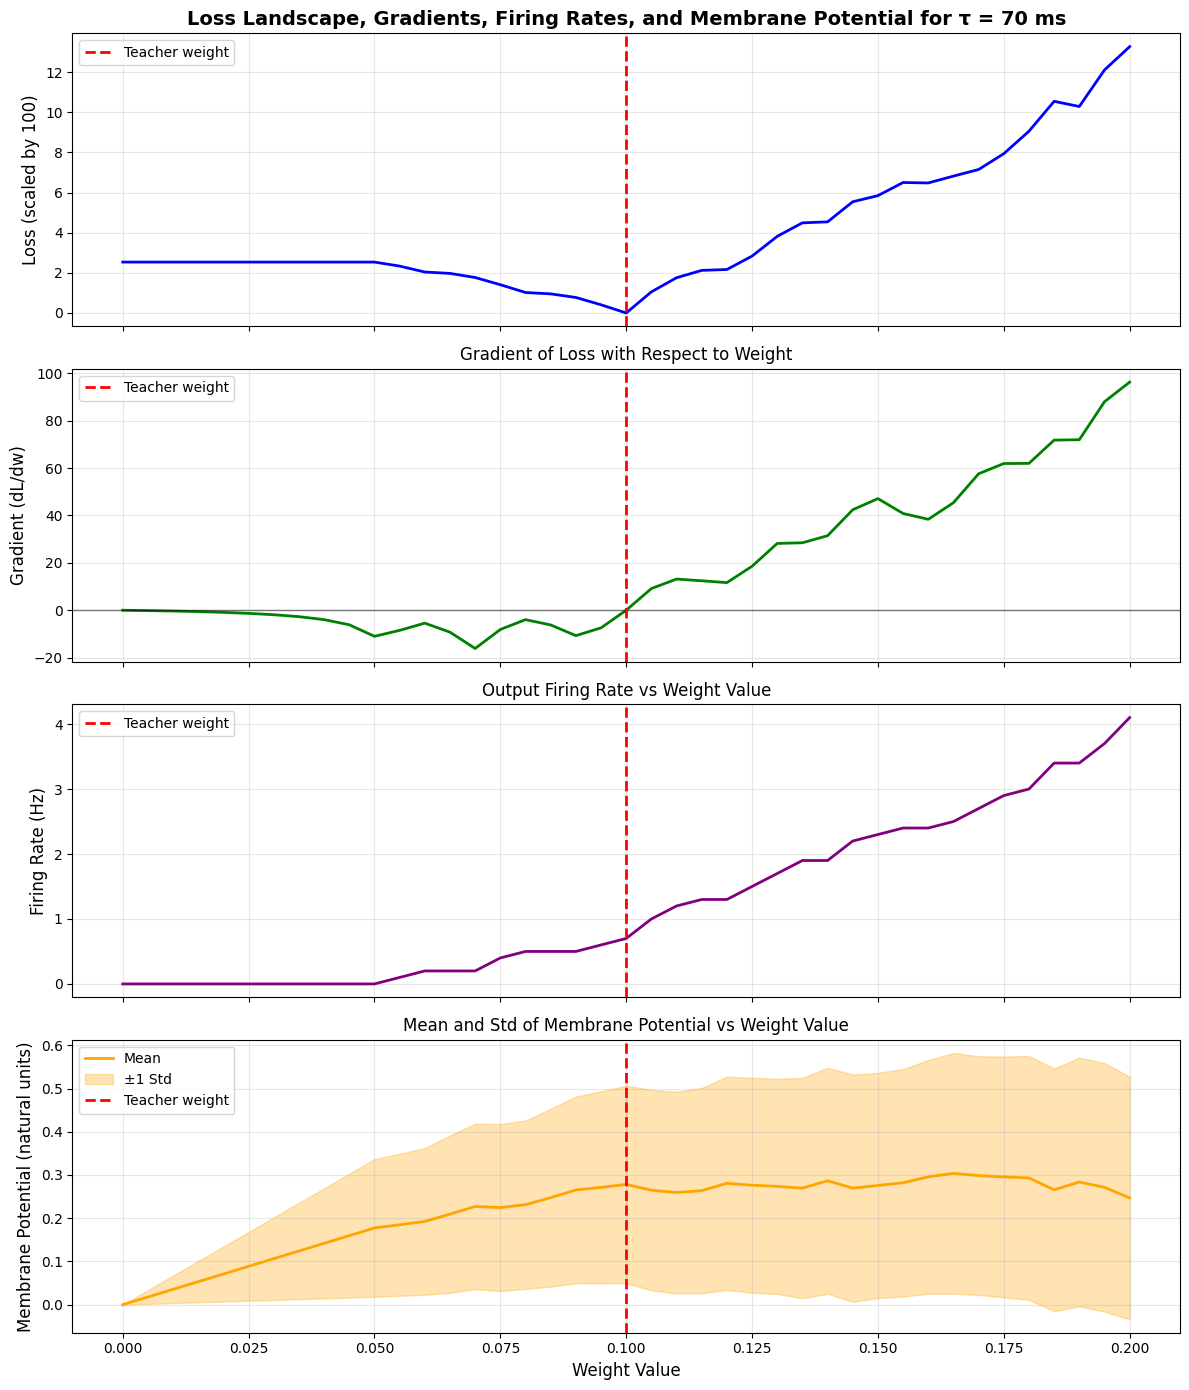


Target weight: 0.100
Gradient at target weight: 0.000000


In [21]:
# Plot loss landscape, gradients, firing rates, and membrane potential
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

# Top subplot: Loss landscape
ax1.plot(weight_values_grad, losses_grad, linewidth=2, color="blue")
ax1.axvline(
    x=model.weights_FF.data[0, 0].item(),
    color="red",
    linestyle="--",
    linewidth=2,
    label="Teacher weight",
)
ax1.set_ylabel("Loss (scaled by 100)", fontsize=12)
ax1.set_title(
    f"Loss Landscape, Gradients, Firing Rates, and Membrane Potential for τ = {tau_fixed:.0f} ms",
    fontsize=14,
    fontweight="bold",
)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Second subplot: Gradients
ax2.plot(weight_values_grad, gradients, linewidth=2, color="green")
ax2.axhline(y=0, color="black", linestyle="-", linewidth=1, alpha=0.5)
ax2.axvline(
    x=model.weights_FF.data[0, 0].item(),
    color="red",
    linestyle="--",
    linewidth=2,
    label="Teacher weight",
)
ax2.set_ylabel("Gradient (dL/dw)", fontsize=12)
ax2.set_title("Gradient of Loss with Respect to Weight", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Third subplot: Firing rates
ax3.plot(weight_values_grad, firing_rates, linewidth=2, color="purple")
ax3.axvline(
    x=model.weights_FF.data[0, 0].item(),
    color="red",
    linestyle="--",
    linewidth=2,
    label="Teacher weight",
)
ax3.set_ylabel("Firing Rate (Hz)", fontsize=12)
ax3.set_title("Output Firing Rate vs Weight Value", fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Bottom subplot: Membrane potential (mean ± std) - Note: natural units (0-1)
mean_voltages_array = np.array(mean_voltages)
std_voltages_array = np.array(std_voltages)
ax4.plot(
    weight_values_grad, mean_voltages_array, linewidth=2, color="orange", label="Mean"
)
ax4.fill_between(
    weight_values_grad,
    mean_voltages_array - std_voltages_array,
    mean_voltages_array + std_voltages_array,
    alpha=0.3,
    color="orange",
    label="±1 Std",
)
ax4.axvline(
    x=model.weights_FF.data[0, 0].item(),
    color="red",
    linestyle="--",
    linewidth=2,
    label="Teacher weight",
)
ax4.set_xlabel("Weight Value", fontsize=12)
ax4.set_ylabel("Membrane Potential (natural units)", fontsize=12)
ax4.set_title("Mean and Std of Membrane Potential vs Weight Value", fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTarget weight: {model.weights_FF.data[0, 0].item():.3f}")
print(
    f"Gradient at target weight: {gradients[np.argmin(np.abs(weight_values_grad - model.weights_FF.data[0, 0].item()))]:.6f}"
)

### Varying surrogate gradient scale

We will now explore how the surrogate gradient scale affects the loss landscape and gradients.

In [22]:
# Compute loss landscape AND gradients for multiple surrgrad_scale values
print(
    "Computing loss landscape and gradients for different surrogate gradient scales..."
)

tau_fixed = 70.0
weight_values_grad = np.arange(0.0, 0.2 + 0.005, 0.005)
surrgrad_scale_values = [0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200]

# Create van Rossum loss function with tau=70ms
van_rossum_loss_70 = VanRossumLoss(tau=tau_fixed, dt=dt, window_size=100, device="cpu")

# Store results for all surrgrad_scale values
all_surrgrad_losses = []
all_surrgrad_gradients = []

for scale_idx, current_surrgrad_scale in enumerate(surrgrad_scale_values):
    print(
        f"\nProcessing surrgrad_scale = {current_surrgrad_scale} ({scale_idx + 1}/{len(surrgrad_scale_values)})"
    )

    losses_grad = []
    gradients = []

    for weight in tqdm(weight_values_grad, desc=f"scale={current_surrgrad_scale}", leave=False):
        # Create temporary model with this weight and surrgrad_scale
        temp_model = FeedforwardCurrentLIFNetwork(
            dt=dt,
            weights_FF=np.array([[weight]]),
            cell_type_indices=cell_type_indices,
            cell_type_indices_FF=cell_type_indices,
            cell_params=cell_params,
            synapse_params_FF=synapse_params_FF,
            surrgrad_scale=current_surrgrad_scale,  # Use current surrgrad_scale
            batch_size=1,
            optimisable="weights",  # Enable gradients
            feedforward_mask=feedforward_mask,
            track_variables=False,
            use_tqdm=False,
        )

        # Get the actual weight parameter (should be a leaf tensor)
        weight_param = list(temp_model.parameters())[0]

        # Compute loss for all chunks WITH gradients
        total_loss = 0.0
        temp_model.reset_state()

        # Zero out any existing gradients
        if weight_param.grad is not None:
            weight_param.grad.zero_()

        for chunk_idx in range(min(10, spike_dataset.num_chunks)):
            input_chunk, target_chunk = spike_dataset[chunk_idx]
            output_spikes = temp_model(input_chunk)  # Returns spikes directly when track_variables=False
            loss = 100 * van_rossum_loss_70(output_spikes, target_chunk)
            loss.backward()  # Compute gradients
            total_loss += loss.item()

        avg_loss = total_loss / min(10, spike_dataset.num_chunks)
        # Access gradient - handle both 1D and 2D cases
        if weight_param.grad.ndim == 1:
            avg_gradient = weight_param.grad[0].item() / min(
                10, spike_dataset.num_chunks
            )
        else:
            avg_gradient = weight_param.grad[0, 0].item() / min(
                10, spike_dataset.num_chunks
            )

        losses_grad.append(avg_loss)
        gradients.append(avg_gradient)

    all_surrgrad_losses.append(losses_grad)
    all_surrgrad_gradients.append(gradients)

    print(f"  Done! Computed {len(losses_grad)} loss and gradient values.")

print("\nAll surrogate gradient scale computations complete!")

Computing loss landscape and gradients for different surrogate gradient scales...

Processing surrgrad_scale = 0.2 (1/10)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 0.5 (2/10)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 1 (3/10)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 2 (4/10)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 5 (5/10)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 10 (6/10)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 20 (7/10)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 50 (8/10)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 100 (9/10)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 200 (10/10)


  Done! Computed 41 loss and gradient values.

All surrogate gradient scale computations complete!


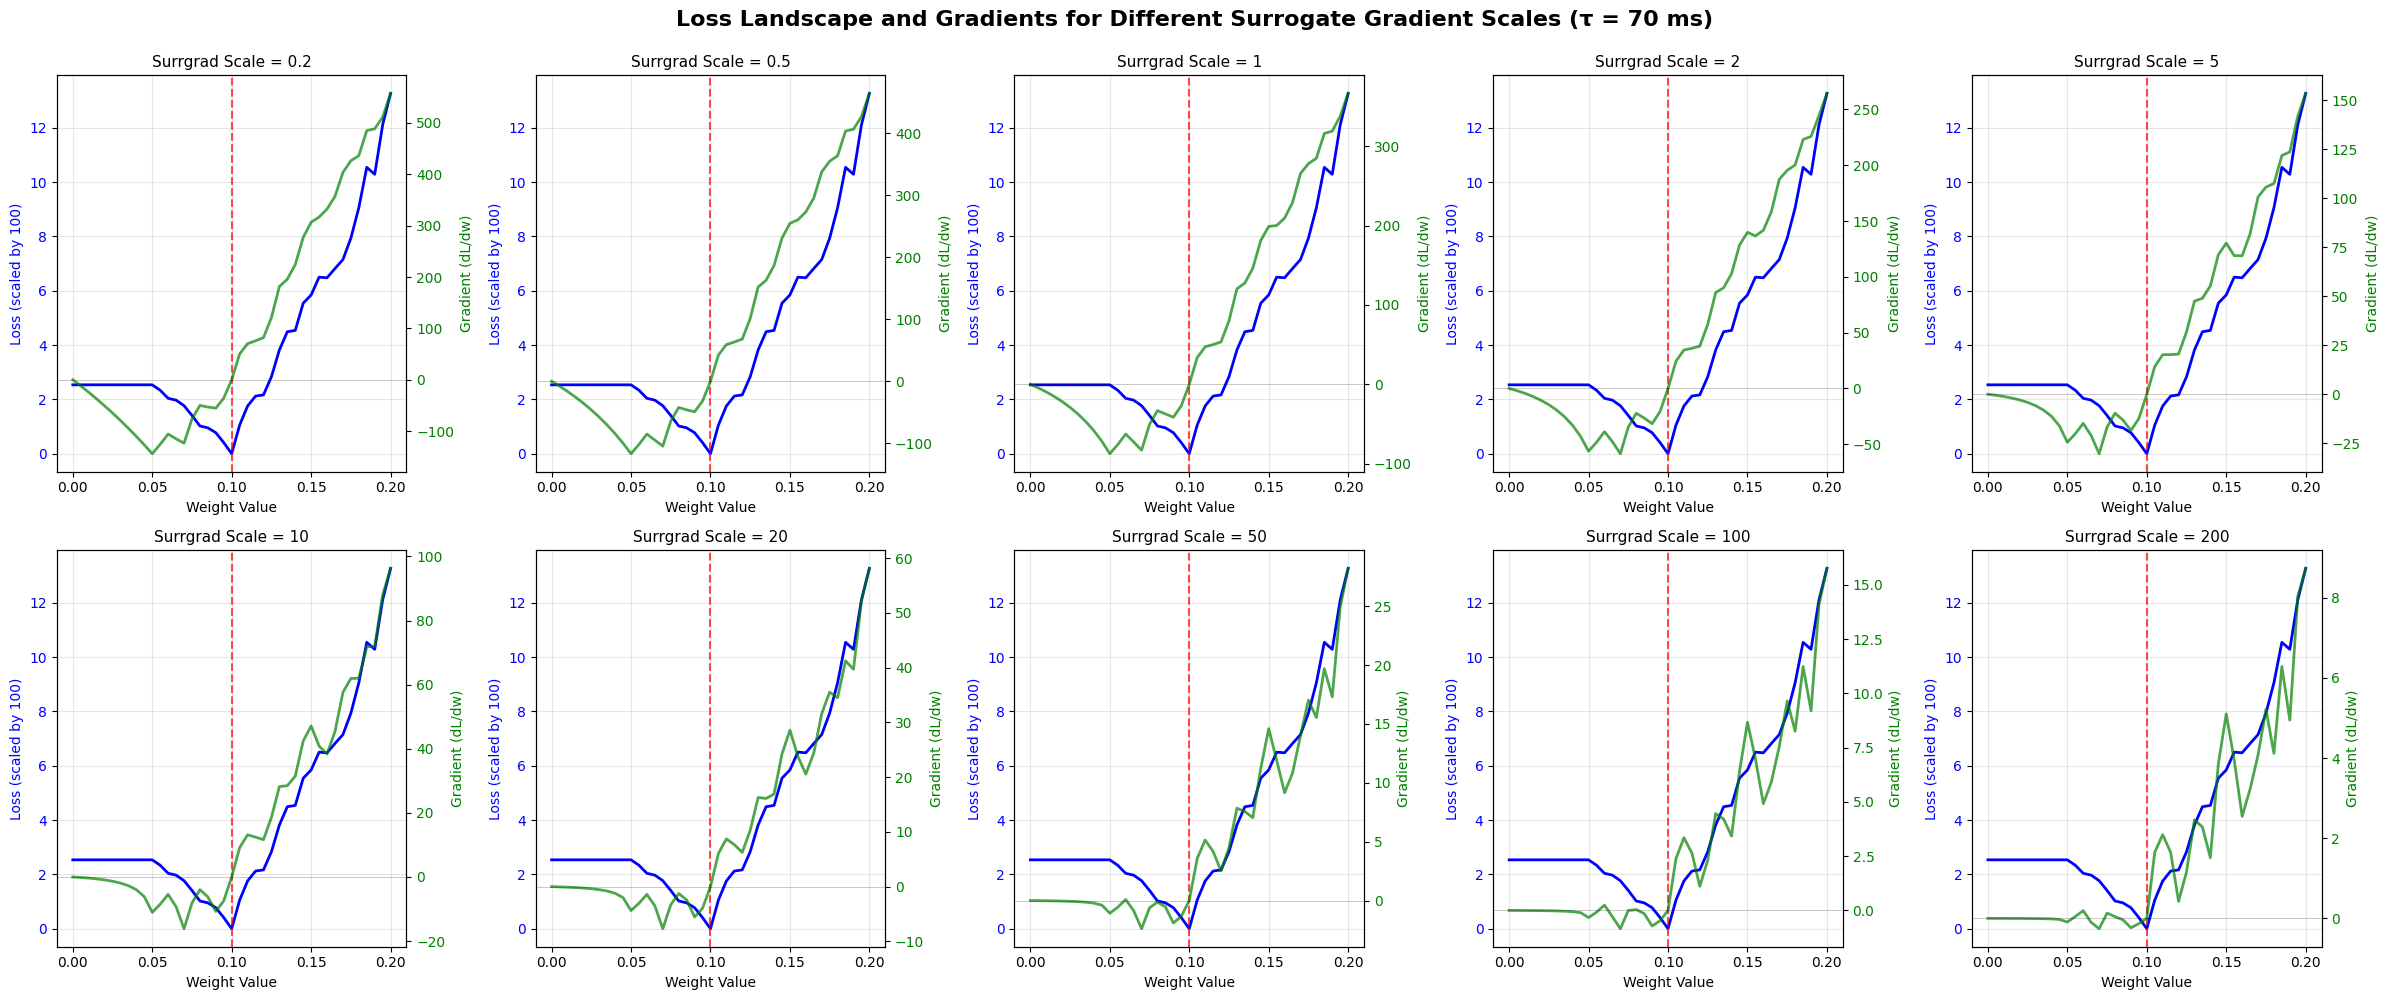


Target weight: 0.100


In [23]:
# Plot loss landscapes and gradients for all surrgrad_scale values
fig, axes = plt.subplots(2, 5, figsize=(24, 10))
axes = axes.flatten()

for scale_idx, surrgrad_scale in enumerate(surrgrad_scale_values):
    ax = axes[scale_idx]

    losses = all_surrgrad_losses[scale_idx]
    gradients_data = all_surrgrad_gradients[scale_idx]

    # Create twin axis for gradients
    ax_grad = ax.twinx()

    # Plot loss landscape
    line1 = ax.plot(weight_values_grad, losses, linewidth=2, color="blue", label="Loss")
    ax.axvline(
        x=model.weights_FF.data[0, 0].item(),
        color="red",
        linestyle="--",
        linewidth=1.5,
        alpha=0.7,
    )
    ax.set_xlabel("Weight Value", fontsize=10)
    ax.set_ylabel("Loss (scaled by 100)", fontsize=10, color="blue")
    ax.tick_params(axis="y", labelcolor="blue")

    # Plot gradients on second axis
    line2 = ax_grad.plot(
        weight_values_grad,
        gradients_data,
        linewidth=2,
        color="green",
        alpha=0.7,
        label="Gradient",
    )
    ax_grad.axhline(y=0, color="black", linestyle="-", linewidth=0.5, alpha=0.3)
    ax_grad.set_ylabel("Gradient (dL/dw)", fontsize=10, color="green")
    ax_grad.tick_params(axis="y", labelcolor="green")

    ax.set_title(f"Surrgrad Scale = {surrgrad_scale}", fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    f"Loss Landscape and Gradients for Different Surrogate Gradient Scales (τ = {tau_fixed:.0f} ms)",
    fontsize=16,
    y=0.995,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

print(f"\nTarget weight: {model.weights_FF.data[0, 0].item():.3f}")

In [24]:
# Print min/max gradient statistics for scales 0.2-200
print("Gradient Statistics by Surrogate Gradient Scale (0.2-200):")
print("=" * 70)
print(f"{'Scale':<10} {'Min Gradient':<20} {'Max Gradient':<20} {'Range':<20}")
print("-" * 70)

for scale_idx, surrgrad_scale in enumerate(surrgrad_scale_values):
    gradients_data = all_surrgrad_gradients[scale_idx]
    min_grad = np.min(gradients_data)
    max_grad = np.max(gradients_data)
    grad_range = max_grad - min_grad

    print(
        f"{surrgrad_scale:<10} {min_grad:<20.6f} {max_grad:<20.6f} {grad_range:<20.6f}"
    )

print("=" * 70)

Gradient Statistics by Surrogate Gradient Scale (0.2-200):
Scale      Min Gradient         Max Gradient         Range               
----------------------------------------------------------------------
0.2        -144.151648          557.714014           701.865662          
0.5        -116.740356          463.976367           580.716724          
1          -87.376514           366.647803           454.024316          
2          -58.488953           264.450708           322.939661          
5          -30.338806           153.545227           183.884033          
10         -16.134750           96.267334            112.402084          
20         -7.684560            58.157721            65.842281           
50         -2.392456            28.209586            30.602041           
100        -0.843054            15.755801            16.598855           
200        -0.258500            8.732141             8.990641            


In [25]:
# Compute loss landscape AND gradients for higher surrogate gradient scales
print(
    "Computing loss landscape and gradients for higher surrogate gradient scales..."
)

tau_fixed = 70.0
weight_values_grad = np.arange(0.0, 0.2 + 0.005, 0.005)
surrgrad_scale_values_high = [500, 1000, 2000, 5000, 10000]

# Create van Rossum loss function with tau=70ms
van_rossum_loss_70 = VanRossumLoss(tau=tau_fixed, dt=dt, window_size=100, device="cpu")

# Store results for all surrgrad_scale values
all_surrgrad_losses_high = []
all_surrgrad_gradients_high = []

for scale_idx, current_surrgrad_scale in enumerate(surrgrad_scale_values_high):
    print(
        f"\nProcessing surrgrad_scale = {current_surrgrad_scale} ({scale_idx + 1}/{len(surrgrad_scale_values_high)})"
    )

    losses_grad = []
    gradients = []

    for weight in tqdm(weight_values_grad, desc=f"scale={current_surrgrad_scale}", leave=False):
        # Create temporary model with this weight and surrgrad_scale
        temp_model = FeedforwardCurrentLIFNetwork(
            dt=dt,
            weights_FF=np.array([[weight]]),
            cell_type_indices=cell_type_indices,
            cell_type_indices_FF=cell_type_indices,
            cell_params=cell_params,
            synapse_params_FF=synapse_params_FF,
            surrgrad_scale=current_surrgrad_scale,  # Use current surrgrad_scale
            batch_size=1,
            optimisable="weights",  # Enable gradients
            feedforward_mask=feedforward_mask,
            track_variables=False,
            use_tqdm=False,
        )

        # Get the actual weight parameter (should be a leaf tensor)
        weight_param = list(temp_model.parameters())[0]

        # Compute loss for all chunks WITH gradients
        total_loss = 0.0
        temp_model.reset_state()

        # Zero out any existing gradients
        if weight_param.grad is not None:
            weight_param.grad.zero_()

        for chunk_idx in range(min(10, spike_dataset.num_chunks)):
            input_chunk, target_chunk = spike_dataset[chunk_idx]
            output_spikes = temp_model(input_chunk)  # Returns spikes directly when track_variables=False
            loss = 100 * van_rossum_loss_70(output_spikes, target_chunk)
            loss.backward()  # Compute gradients
            total_loss += loss.item()

        avg_loss = total_loss / min(10, spike_dataset.num_chunks)
        # Access gradient - handle both 1D and 2D cases
        if weight_param.grad.ndim == 1:
            avg_gradient = weight_param.grad[0].item() / min(
                10, spike_dataset.num_chunks
            )
        else:
            avg_gradient = weight_param.grad[0, 0].item() / min(
                10, spike_dataset.num_chunks
            )

        losses_grad.append(avg_loss)
        gradients.append(avg_gradient)

    all_surrgrad_losses_high.append(losses_grad)
    all_surrgrad_gradients_high.append(gradients)

    print(f"  Done! Computed {len(losses_grad)} loss and gradient values.")

print("\nAll high surrogate gradient scale computations complete!")

Computing loss landscape and gradients for higher surrogate gradient scales...

Processing surrgrad_scale = 500 (1/5)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 1000 (2/5)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 2000 (3/5)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 5000 (4/5)


  Done! Computed 41 loss and gradient values.

Processing surrgrad_scale = 10000 (5/5)


  Done! Computed 41 loss and gradient values.

All high surrogate gradient scale computations complete!


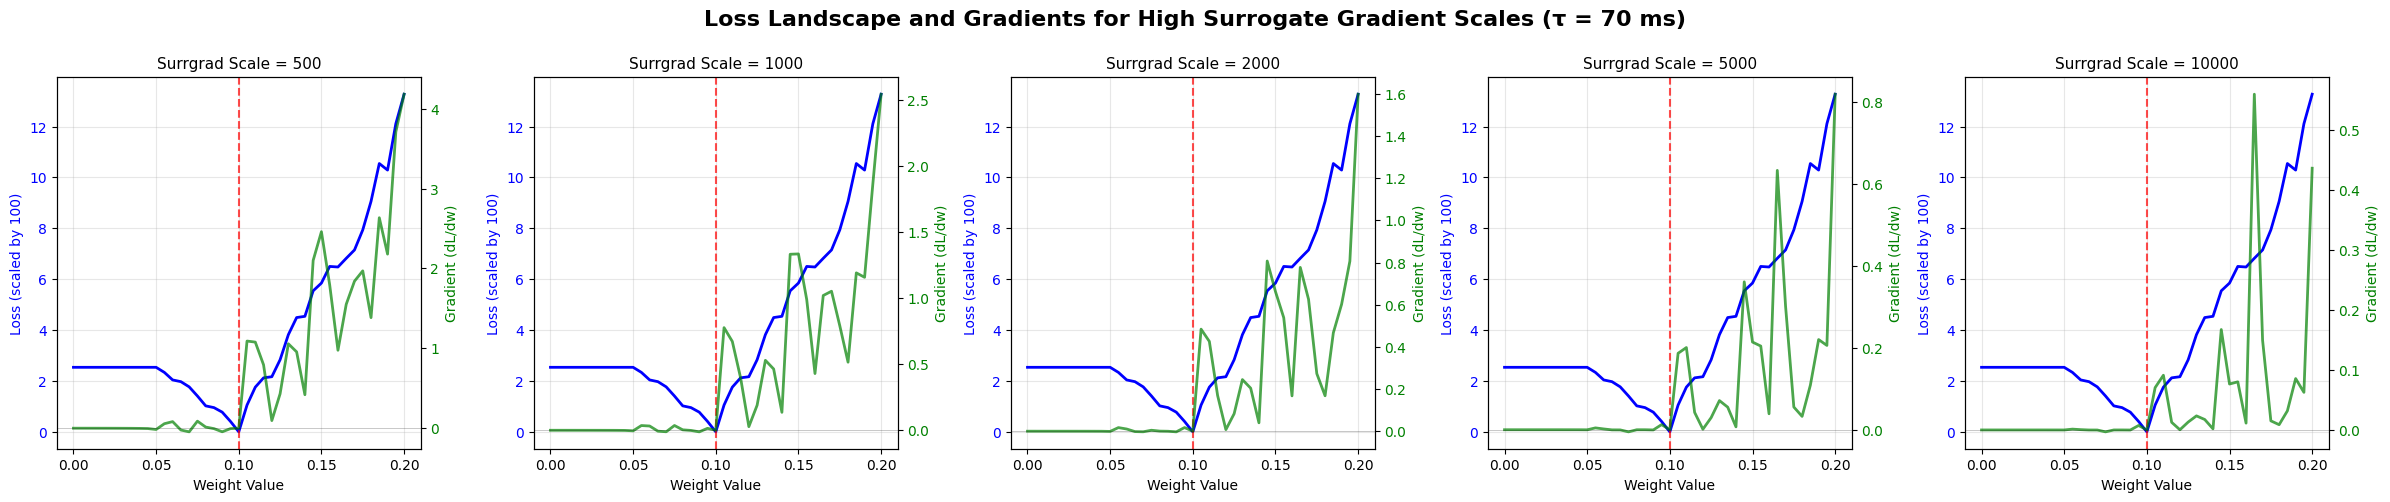


Target weight: 0.100


In [26]:
# Plot loss landscapes and gradients for high surrgrad_scale values
fig, axes = plt.subplots(1, 5, figsize=(24, 5))
axes = axes.flatten()

for scale_idx, current_surrgrad_scale in enumerate(surrgrad_scale_values_high):
    ax = axes[scale_idx]

    losses = all_surrgrad_losses_high[scale_idx]
    gradients_data = all_surrgrad_gradients_high[scale_idx]

    # Create twin axis for gradients
    ax_grad = ax.twinx()

    # Plot loss landscape
    line1 = ax.plot(weight_values_grad, losses, linewidth=2, color="blue", label="Loss")
    ax.axvline(
        x=model.weights_FF.data[0, 0].item(),
        color="red",
        linestyle="--",
        linewidth=1.5,
        alpha=0.7,
    )
    ax.set_xlabel("Weight Value", fontsize=10)
    ax.set_ylabel("Loss (scaled by 100)", fontsize=10, color="blue")
    ax.tick_params(axis="y", labelcolor="blue")

    # Plot gradients on second axis
    line2 = ax_grad.plot(
        weight_values_grad,
        gradients_data,
        linewidth=2,
        color="green",
        alpha=0.7,
        label="Gradient",
    )
    ax_grad.axhline(y=0, color="black", linestyle="-", linewidth=0.5, alpha=0.3)
    ax_grad.set_ylabel("Gradient (dL/dw)", fontsize=10, color="green")
    ax_grad.tick_params(axis="y", labelcolor="green")

    ax.set_title(f"Surrgrad Scale = {current_surrgrad_scale}", fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    f"Loss Landscape and Gradients for High Surrogate Gradient Scales (τ = {tau_fixed:.0f} ms)",
    fontsize=16,
    y=0.995,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

print(f"\nTarget weight: {model.weights_FF.data[0, 0].item():.3f}")

In [27]:
# Print min/max gradient statistics for high scales (500-10000)
print("Gradient Statistics by Surrogate Gradient Scale (500-10000):")
print("=" * 70)
print(f"{'Scale':<10} {'Min Gradient':<20} {'Max Gradient':<20} {'Range':<20}")
print("-" * 70)

for scale_idx, current_surrgrad_scale in enumerate(surrgrad_scale_values_high):
    gradients_data = all_surrgrad_gradients_high[scale_idx]
    min_grad = np.min(gradients_data)
    max_grad = np.max(gradients_data)
    grad_range = max_grad - min_grad

    print(
        f"{current_surrgrad_scale:<10} {min_grad:<20.6f} {max_grad:<20.6f} {grad_range:<20.6f}"
    )

print("=" * 70)

Gradient Statistics by Surrogate Gradient Scale (500-10000):
Scale      Min Gradient         Max Gradient         Range               
----------------------------------------------------------------------
500        -0.045614            4.180351             4.225965            
1000       -0.011928            2.546284             2.558212            
2000       -0.003062            1.598466             1.601528            
5000       -0.005138            0.819527             0.824665            
10000      -0.003149            0.559210             0.562359            
